## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geoim' #dataset-compression
TRANSFORM = 'stft-normal_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
normal_intensity_stft_1e5geoim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geoim\\stft\\normal_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = int(10) #Change to len(group_data_map) to use all bands

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


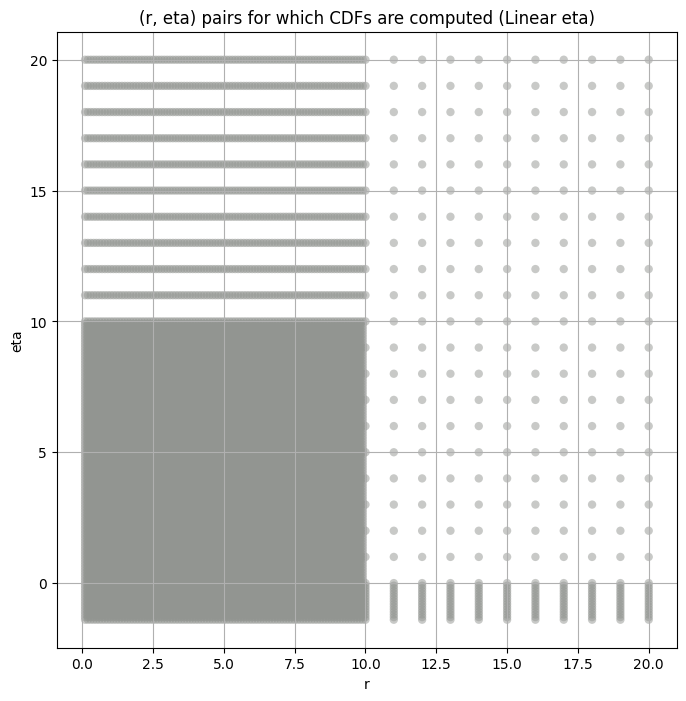

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,35.930350,30.706068,46.672894,65.41619,13.719309,295.32263,6119361.0
3,24.800020,19.868608,36.966910,162.30330,23.848286,629.88650,7252576.0
4,22.749765,17.699577,34.964066,197.49574,34.756207,726.18604,8839077.0
5,12.425893,9.770795,17.029290,119.05834,39.765420,404.69530,10425578.0
6,11.137615,8.458925,17.432486,220.17760,43.897568,770.97736,12465365.0
7,4.457747,3.310526,7.184396,260.92682,46.247795,878.40810,14958438.0
8,0.989298,0.736347,1.620235,274.10986,43.866005,922.87164,17904797.0
9,0.287136,0.203042,0.548710,512.60270,57.122345,1514.20340,28783661.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,35.930350,35.930351,32.383686,31.061338,30.062201,29.233244,27.875710,26.767445,25.814825,24.973772,24.220621,22.327950
3,24.800020,24.800020,21.069948,19.814962,18.893154,18.147913,16.962854,16.031342,15.255982,14.591880,14.010572,12.604817
4,22.749765,22.749765,19.125170,17.788498,16.778173,15.952385,14.628488,13.574320,12.693907,11.938560,11.278127,9.696846
5,12.425893,12.425893,10.587779,9.800017,9.204182,8.714137,7.923895,7.295215,6.772716,6.325863,5.935969,5.005038
6,11.137615,11.137615,9.181695,8.453270,7.903051,7.451577,6.730096,6.161077,5.689966,5.288591,4.940319,4.113588
7,4.457747,4.457747,3.591740,3.285433,3.060612,2.879241,2.594551,2.372909,2.191582,2.038490,1.906552,1.596861
8,0.989298,0.989298,0.799774,0.734735,0.686626,0.647617,0.585639,0.536915,0.496729,0.462590,0.433000,0.363092
9,0.287136,0.287136,0.222772,0.201508,0.185643,0.172818,0.152608,0.137019,0.124402,0.113888,0.104944,0.084496


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.0038841028188160154 35.93035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.006450657577346863 32.383686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.006153430737760646 31.061338


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.004802656783105874 30.0622


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.003536230575240662 29.233244


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.0036268366504982504 27.87571


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.0048882612516960924 26.767445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.006270669306696383 25.814825


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.006538791016270973 24.973772


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.006693183299342643 24.220621


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.007889763682481139 22.32795
Number of samples: 100000, Without approximation : 6119361.0


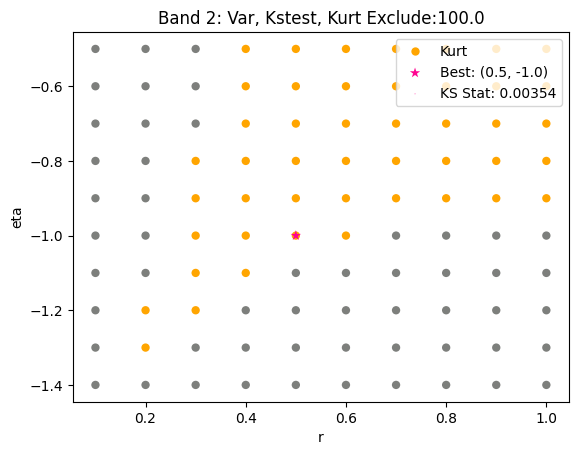

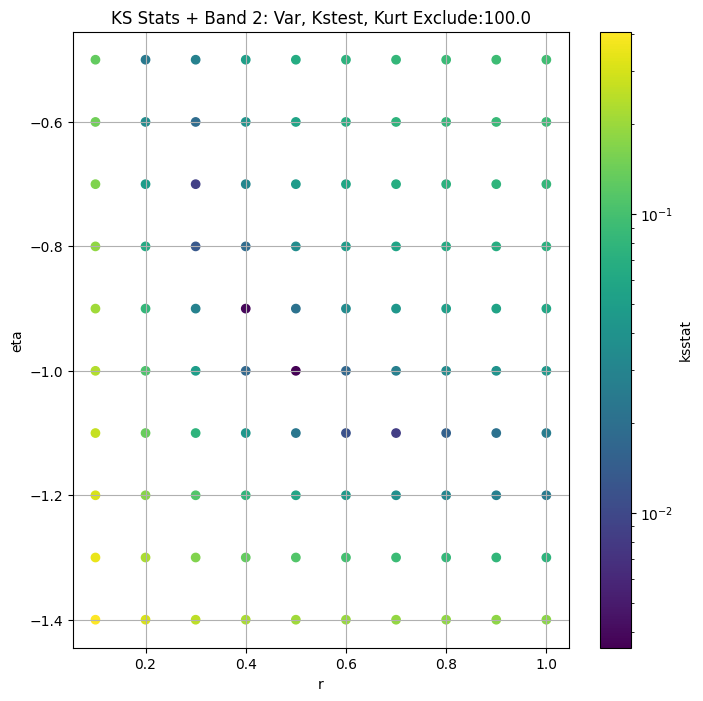

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.004663926668994622 24.80002


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.010367455948426363 21.069948


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.007474436185739841 19.814962


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.005362412792520588 18.893154


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.0037272589909863596 18.147913


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.006446514005848836 16.962854


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.005540950301698433 16.031342


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.005135022882163207 15.255982


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.006525953380467769 14.59188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.007826987611669334 14.010572


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.008005218557540245 12.604817
Number of samples: 100000, Without approximation : 7252576.0


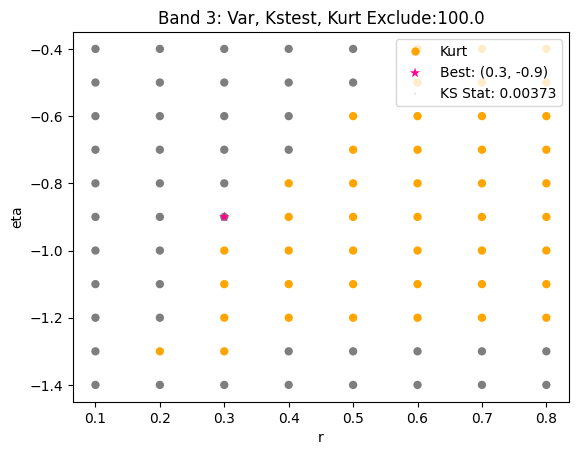

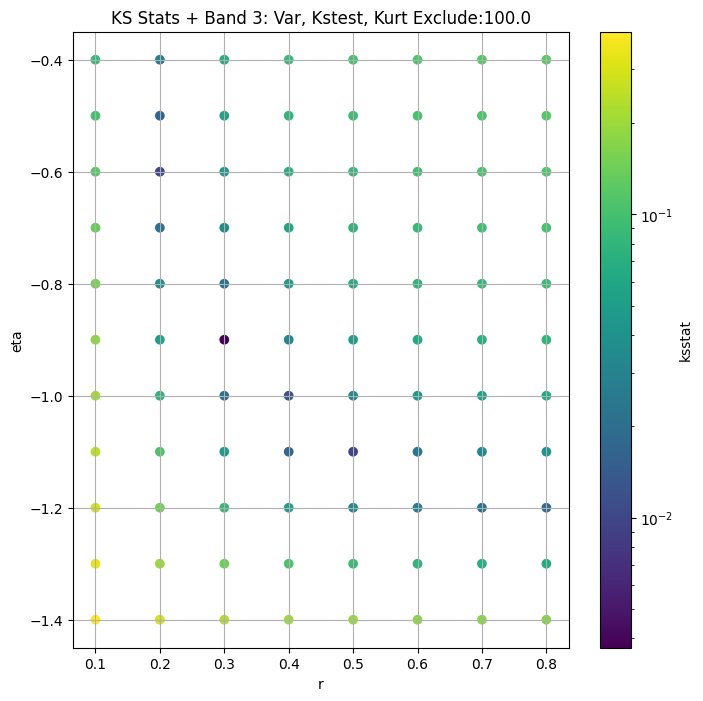

####
Band  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.003767722307048471 22.749765


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.0077981249635353245 19.12517


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.005252541223190521 17.788498


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.006614813551304222 16.778173


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.00807380862173468 15.952385


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.008041414125404968 14.628488


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.010577953091059522 13.57432


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.01087412076812111 12.693907


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.007738408017332388 11.9385605


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.008647532735625619 11.278127


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.009090821372756953 9.696846
Number of samples: 100000, Without approximation : 8839077.0


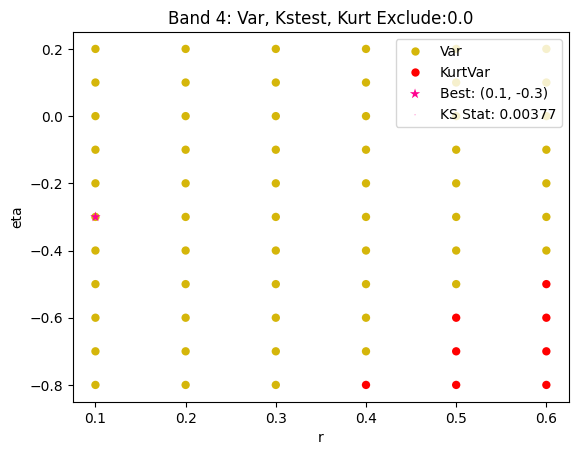

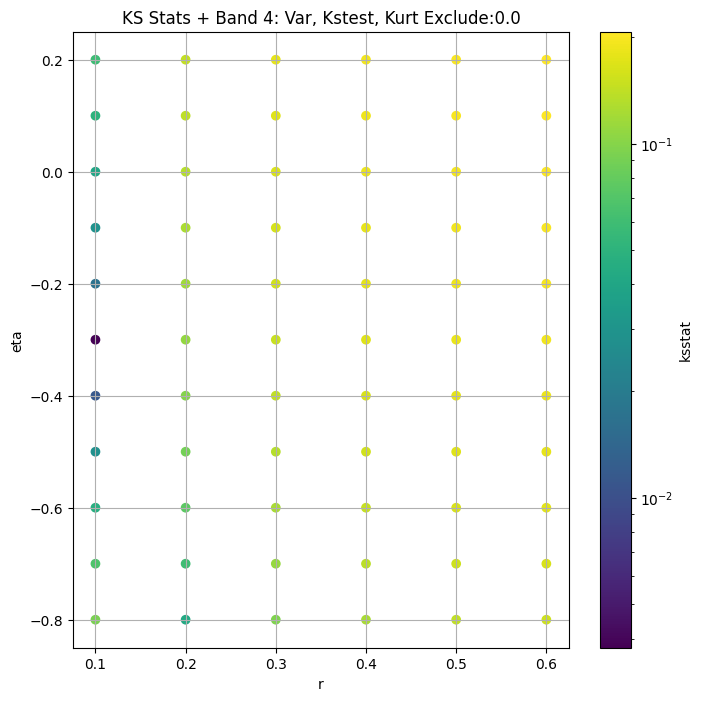

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.011074135027994814 12.425893


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.013029851948351823 10.587779


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.008916976332255744 9.800017


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0077540608278859335 9.204182


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.00916917089050151 8.714137


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.007319932377146343 7.9238954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.007779438083529055 7.2952147


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.008792706442758303 6.7727156


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.009061390895412604 6.325863


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.009981509559349545 5.9359694


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.009878598965484134 5.0050383
Number of samples: 100000, Without approximation : 10425578.0


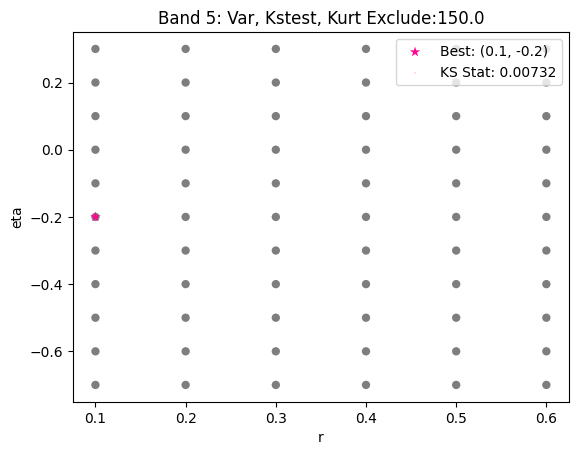

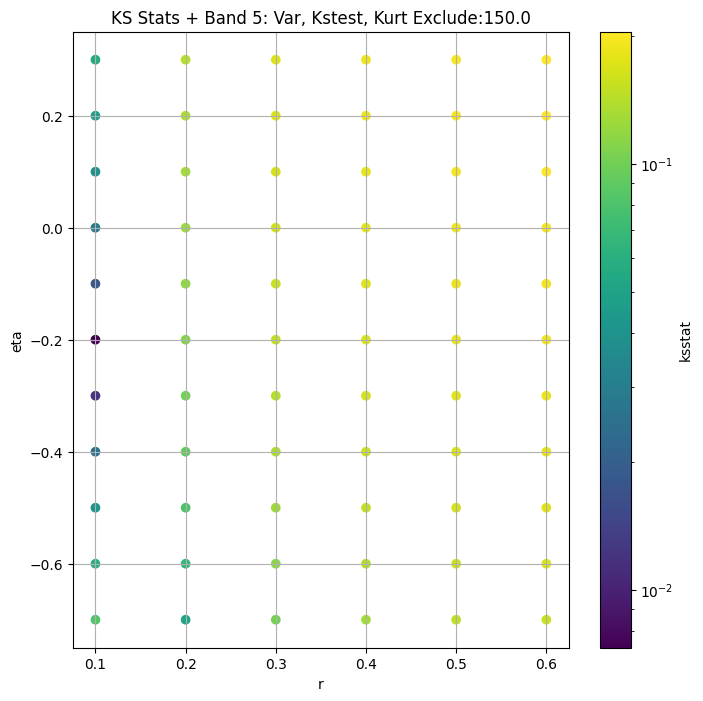

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.018714062472657944 11.137615


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.015225711368812234 9.181695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.0144208260547396 8.45327


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.011083332568539106 7.903051


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.01023308146061952 7.4515767


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.011267477795060016 6.730096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.007129140724118551 6.1610775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.008565659187886543 5.689966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.00840007554609245 5.2885914


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.009200790572649893 4.9403186


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.0098284843411931 4.113588
Number of samples: 100000, Without approximation : 12465365.0


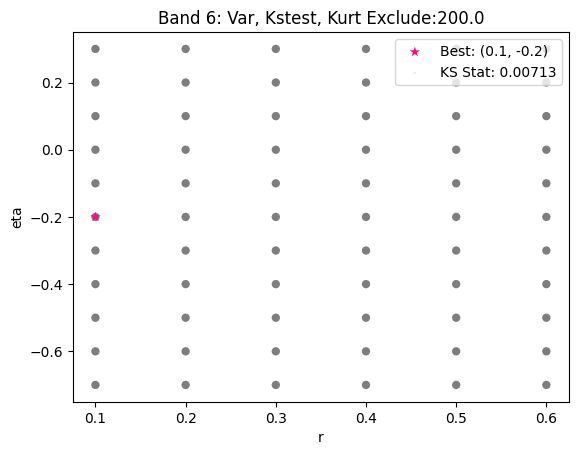

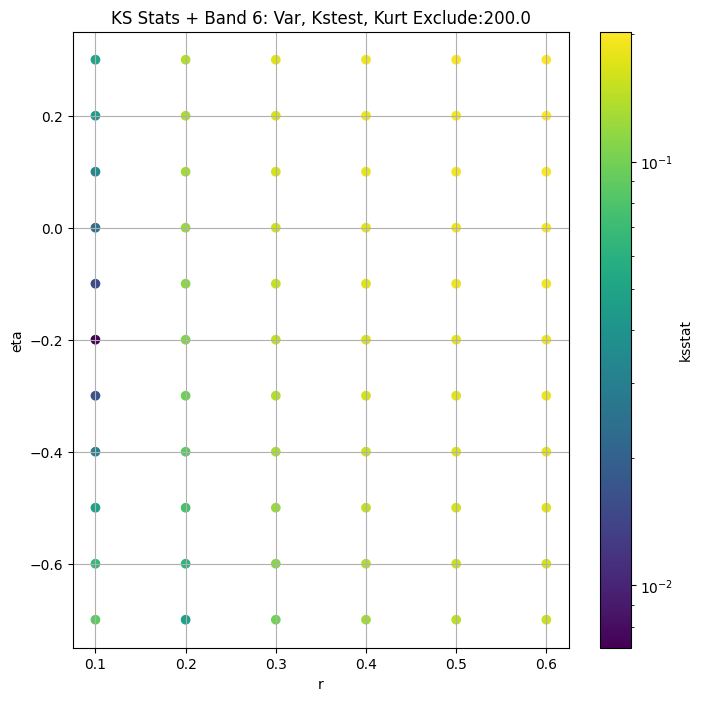

####
Band  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.017704608090397977 4.457747


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.012962851181123058 3.5917401


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.015755971249161227 3.2854328


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.012797818428419094 3.0606122


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.009830820644734506 2.8792412


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.012034441550589303 2.5945513


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.007081255862398161 2.3729093


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.009393949910355803 2.1915822


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.008235520210738013 2.0384896


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.009115856963340808 1.9065521


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.010730120717731237 1.5968605
Number of samples: 100000, Without approximation : 14958438.0


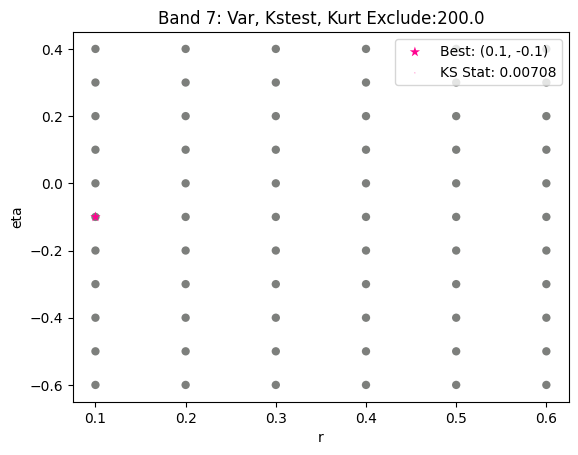

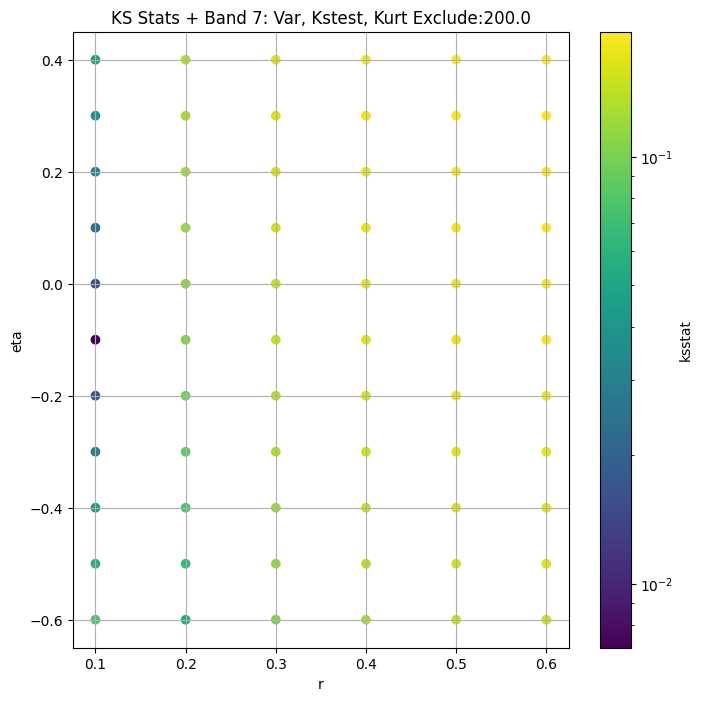

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.022004657780005932 0.9892978


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.018539482689802267 0.7997741


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.019534751973004805 0.7347349


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.015845138095000322 0.68662626


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.01626588252276795 0.64761674


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.014301197555631306 0.5856387


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.014234479354270357 0.53691524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.011744183382868867 0.4967288


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.011762836123498766 0.4625904


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.010163999839269522 0.43300027


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010164266960399652 0.36309233
Number of samples: 100000, Without approximation : 17904797.0


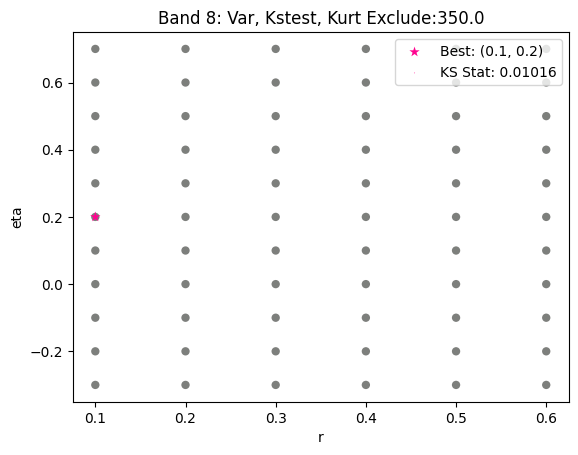

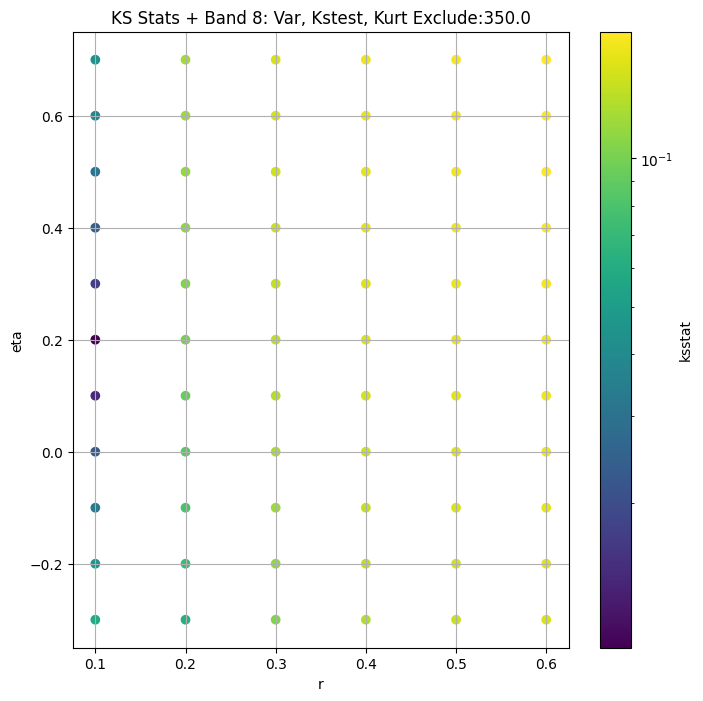

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.02878867174771449 0.28713587


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.025295106454919225 0.22277187


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.02380645282354865 0.2015076


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.020717356434310774 0.18564339


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.023315141520810934 0.17281817


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.017967986367289912 0.1526081


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.017690534817002 0.1370194


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.01667740847882415 0.12440172


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.013764752668010471 0.113887616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.015054782008452727 0.10494395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009185243598588577 0.0844962
Number of samples: 100000, Without approximation : 28783661.0


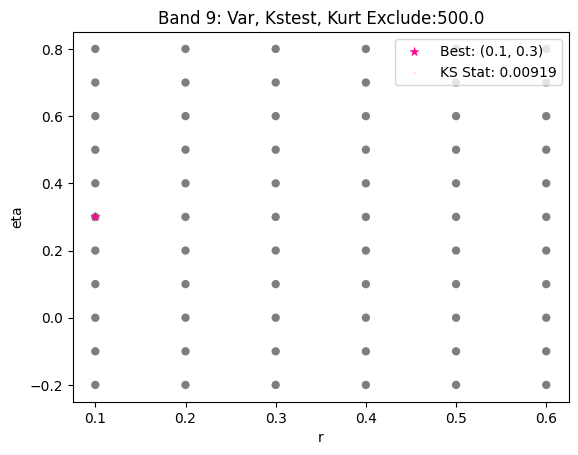

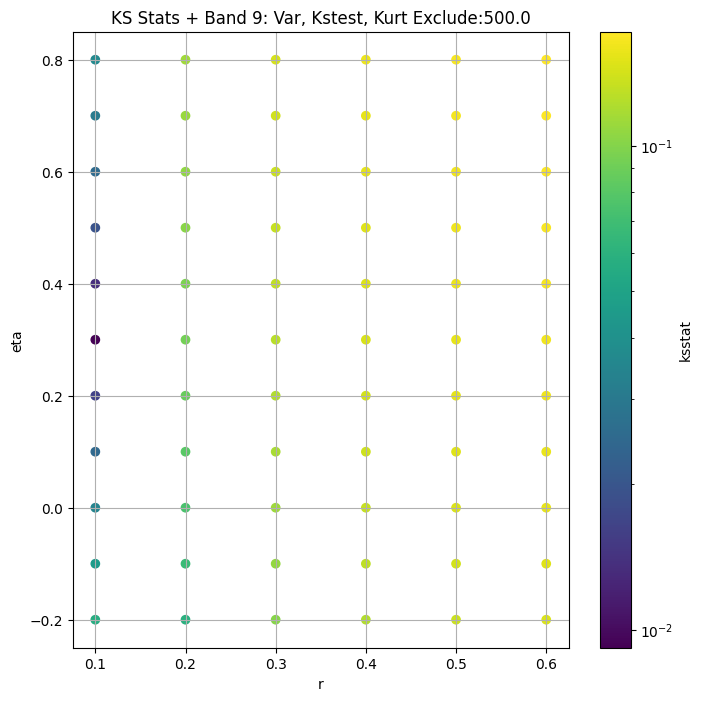

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,35.930350,30.706068,46.672894,65.41619,13.719309,295.32263,6119361.0,0.003536,0.5,-1.0,1.461662e+01,100.0,29.233244,0.000549
3,24.800020,19.868608,36.966910,162.30330,23.848286,629.88650,7252576.0,0.003727,0.3,-0.9,4.522399e-01,100.0,18.147913,0.000504
4,22.749765,17.699577,34.964066,197.49574,34.756207,726.18604,8839077.0,0.003768,0.1,-0.3,1.777415e-11,0.0,22.749765,0.000457
5,12.425893,9.770795,17.029290,119.05834,39.765420,404.69530,10425578.0,0.007320,0.1,-0.2,3.376829e-12,150.0,7.923895,0.000421
6,11.137615,8.458925,17.432486,220.17760,43.897568,770.97736,12465365.0,0.007129,0.1,-0.2,2.625591e-12,200.0,6.161078,0.000385
7,4.457747,3.310526,7.184396,260.92682,46.247795,878.40810,14958438.0,0.007081,0.1,-0.1,5.715668e-13,200.0,2.372909,0.000351
8,0.989298,0.736347,1.620235,274.10986,43.866005,922.87164,17904797.0,0.010164,0.1,0.2,2.246408e-14,350.0,0.433000,0.000321
9,0.287136,0.203042,0.548710,512.60270,57.122345,1514.20340,28783661.0,0.009185,0.1,0.3,2.760088e-15,500.0,0.084496,0.000253


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + 100 = 200, ksstat: 0.004072282206992503, var: 26.767444610595703


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + 75 = 175, ksstat: 0.0036380536372553687, var: 27.297975540161133


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + 50 = 150, ksstat: 0.003467999346341507, var: 27.875709533691406


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + 25 = 125, ksstat: 0.0030554539028180075, var: 28.514572143554688


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + 0 = 100, ksstat: 0.0025122104048212503, var: 29.233243942260742


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + -25 = 75, ksstat: 0.002275986814452069, var: 30.06220054626465


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + -50 = 50, ksstat: 0.0018238970871940277, var: 31.061338424682617


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + -75 = 25, ksstat: 0.0012330802758611092, var: 32.38368606567383


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
band 2, 100.0 + -100 = 0, ksstat: 0.00221533142990632, var: 35.93035125732422
Number of samples: 100000, Without approximation : 6119361.0


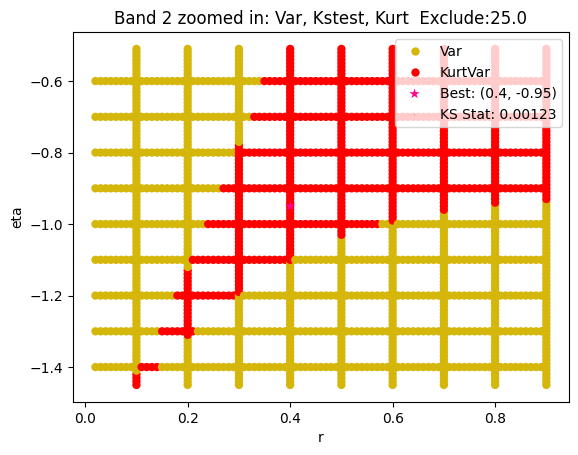

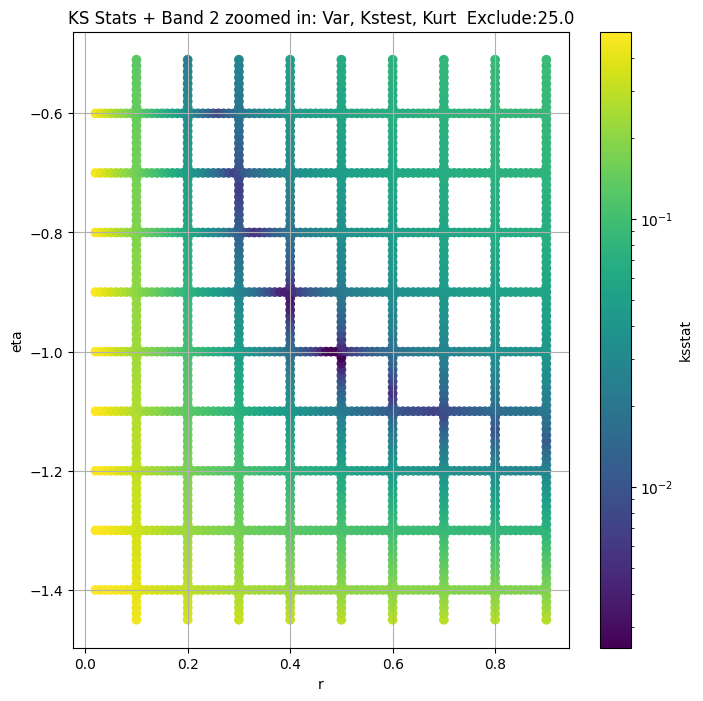

Band 3


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + 100 = 200, ksstat: 0.004034080519763832, var: 16.031341552734375


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + 75 = 175, ksstat: 0.003702942263740707, var: 16.472932815551758


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + 50 = 150, ksstat: 0.0034032816533089427, var: 16.962854385375977


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + 25 = 125, ksstat: 0.003412505009461664, var: 17.51441764831543


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + 0 = 100, ksstat: 0.0036317478920673274, var: 18.147912979125977


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + -25 = 75, ksstat: 0.0024477023710358925, var: 18.89315414428711


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + -50 = 50, ksstat: 0.0022171804308718235, var: 19.81496238708496


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + -75 = 25, ksstat: 0.0024260897684449945, var: 21.069948196411133


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 100.0 + -100 = 0, ksstat: 0.0031230277601866085, var: 24.800020217895508
Number of samples: 100000, Without approximation : 7252576.0


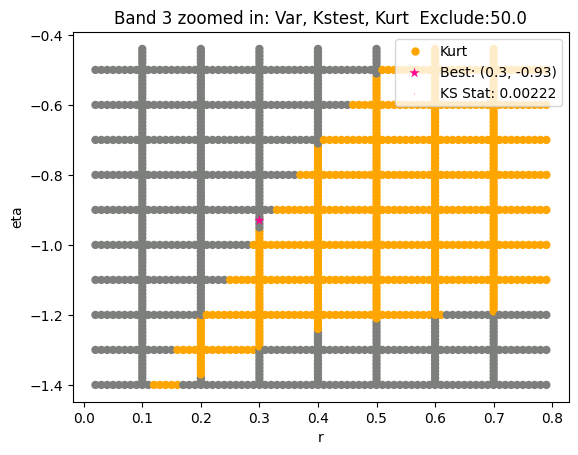

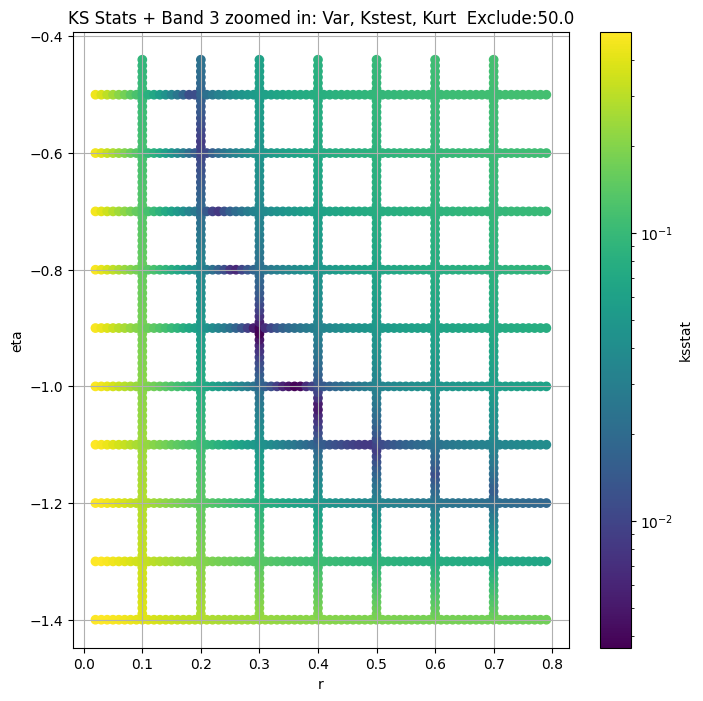

Band 4


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 4, 0.0 + 100 = 100, ksstat: 0.00547181904192557, var: 15.952384948730469


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 4, 0.0 + 75 = 75, ksstat: 0.004667181135070635, var: 16.778173446655273


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 4, 0.0 + 50 = 50, ksstat: 0.004906105302974473, var: 17.788497924804688


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 4, 0.0 + 25 = 25, ksstat: 0.003970204155792353, var: 19.12516975402832


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 4, 0.0 + 0 = 0, ksstat: 0.0024992684303381703, var: 22.749765396118164
Number of samples: 100000, Without approximation : 8839077.0


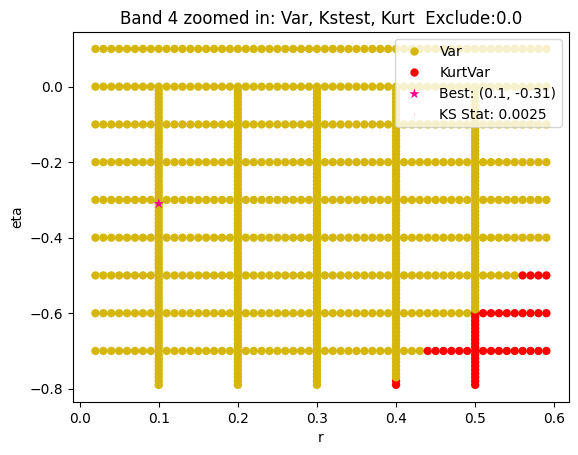

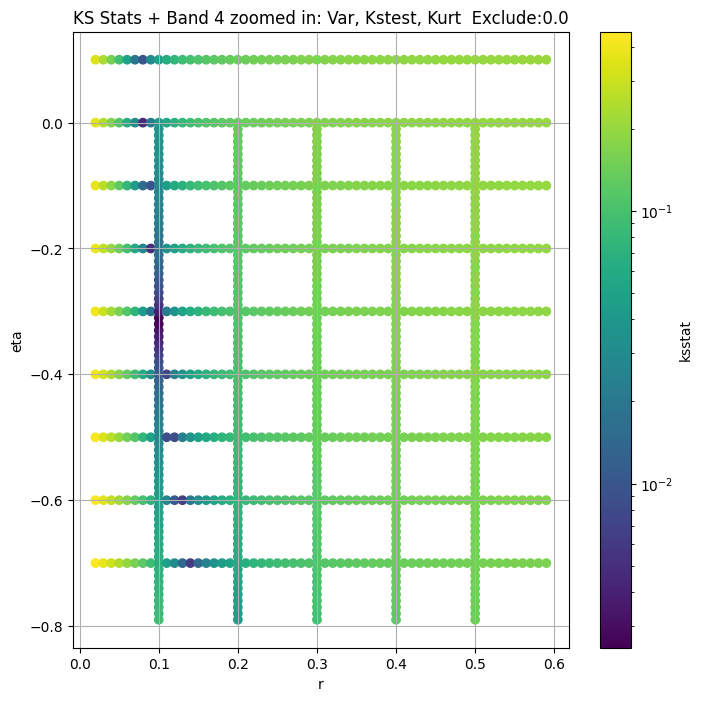

Band 5


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + 100 = 250, ksstat: 0.007776010453634186, var: 6.7727155685424805


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + 75 = 225, ksstat: 0.007505748876303325, var: 7.022934436798096


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + 50 = 200, ksstat: 0.007328487245328056, var: 7.295214653015137


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + 25 = 175, ksstat: 0.0071522522589120945, var: 7.593750476837158


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + 0 = 150, ksstat: 0.0067998931635417596, var: 7.923895359039307


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + -25 = 125, ksstat: 0.006419573011374521, var: 8.293777465820312


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + -50 = 100, ksstat: 0.006191680105944388, var: 8.714137077331543


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + -75 = 75, ksstat: 0.006861939636214565, var: 9.204181671142578


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 5, 150.0 + -100 = 50, ksstat: 0.007836340848478007, var: 9.800017356872559
Number of samples: 100000, Without approximation : 10425578.0


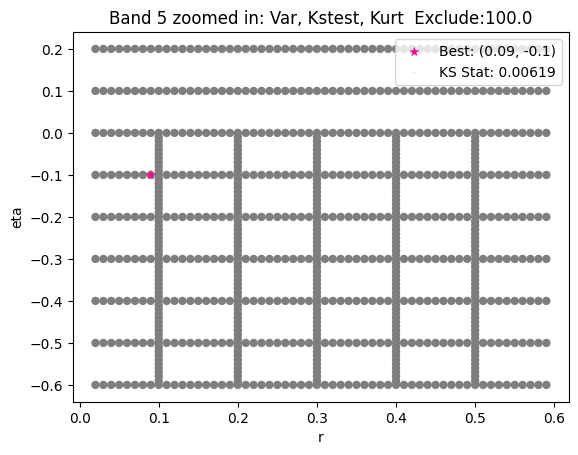

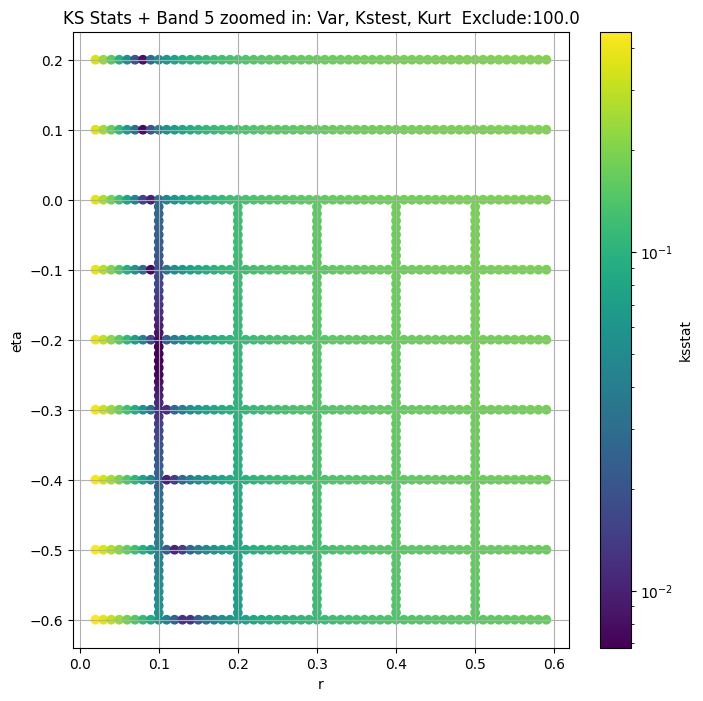

Band 6


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + 100 = 300, ksstat: 0.00821921123679154, var: 5.288591384887695


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + 75 = 275, ksstat: 0.007812186866749947, var: 5.481787204742432


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + 50 = 250, ksstat: 0.007645334946495087, var: 5.689966201782227


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + 25 = 225, ksstat: 0.007439657159739524, var: 5.915489673614502


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + 0 = 200, ksstat: 0.007129140724118551, var: 6.161077499389648


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + -25 = 175, ksstat: 0.007294211430857733, var: 6.43075704574585


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + -50 = 150, ksstat: 0.0073239935191606875, var: 6.730095863342285


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + -75 = 125, ksstat: 0.006825926270174976, var: 7.066610336303711


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 200.0 + -100 = 100, ksstat: 0.009240611556509903, var: 7.4515767097473145
Number of samples: 100000, Without approximation : 12465365.0


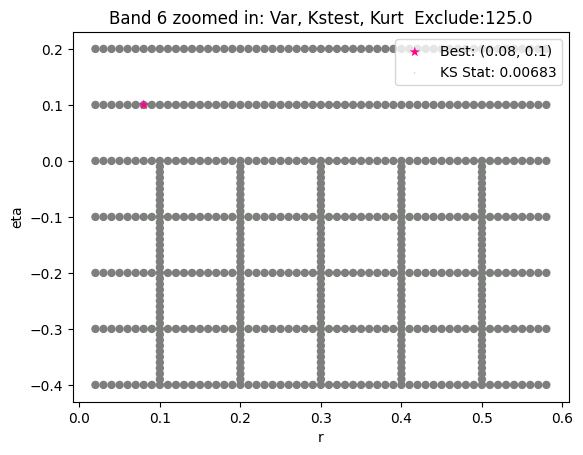

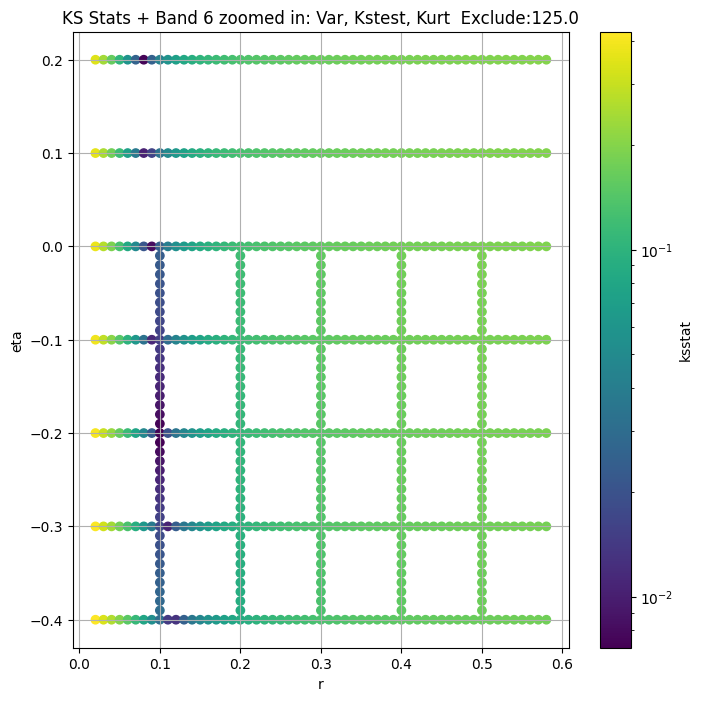

Band 7


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + 100 = 300, ksstat: 0.0077740841016359485, var: 2.038489580154419


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + 75 = 275, ksstat: 0.007821605778809972, var: 2.112001657485962


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + 50 = 250, ksstat: 0.007362252464088781, var: 2.191582202911377


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + 25 = 225, ksstat: 0.007158936682673376, var: 2.2781150341033936


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + 0 = 200, ksstat: 0.007081255862398161, var: 2.3729093074798584


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + -25 = 175, ksstat: 0.007674862560876683, var: 2.4777019023895264


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + -50 = 150, ksstat: 0.008523947911081575, var: 2.5945513248443604


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + -75 = 125, ksstat: 0.007887657566146067, var: 2.726799488067627


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 7, 200.0 + -100 = 100, ksstat: 0.009297533720332374, var: 2.8792412281036377
Number of samples: 100000, Without approximation : 14958438.0


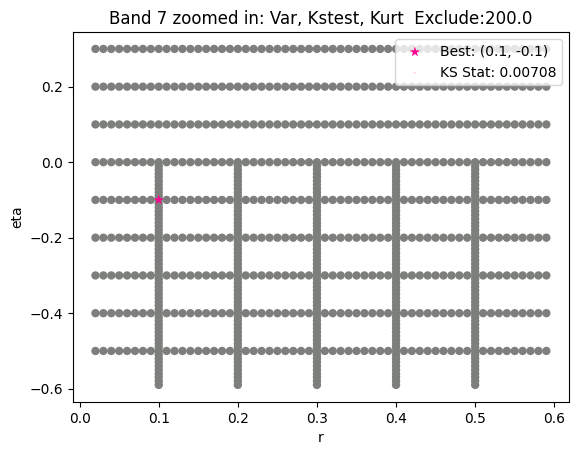

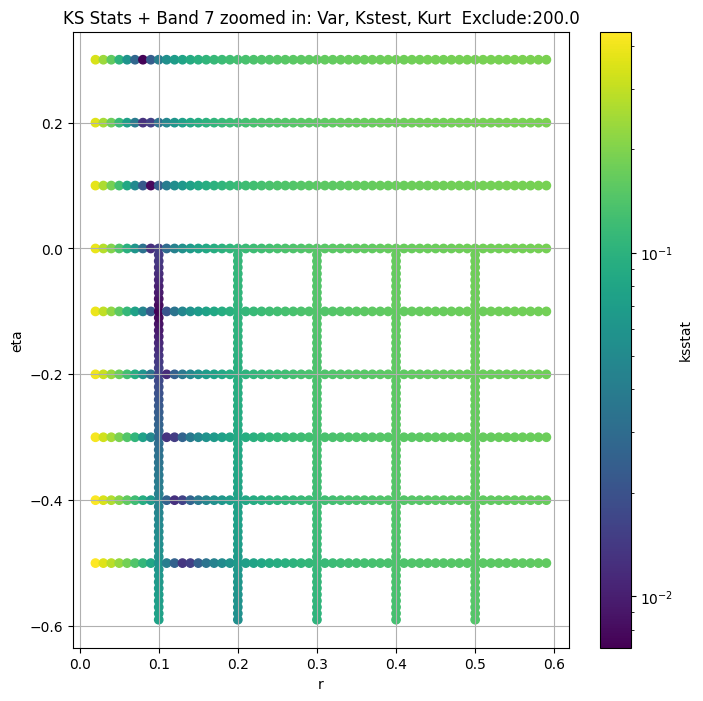

Band 8


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + 100 = 450, ksstat: 0.009369178997052884, var: 0.3838501572608948


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + 75 = 425, ksstat: 0.009276763109876239, var: 0.39508745074272156


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + 50 = 400, ksstat: 0.009221650429586895, var: 0.4069764018058777


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + 25 = 375, ksstat: 0.008595366724100608, var: 0.4195890724658966


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + 0 = 350, ksstat: 0.008801701717335408, var: 0.43300026655197144


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + -25 = 325, ksstat: 0.00888273711427856, var: 0.44729775190353394


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + -50 = 300, ksstat: 0.008635610998787291, var: 0.46259039640426636


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + -75 = 275, ksstat: 0.009906044744529496, var: 0.4790136516094208


  0%|          | 0/715 [00:00<?, ?it/s]

Finding Minimum after computing 715 CDFs
band 8, 350.0 + -100 = 250, ksstat: 0.010947191416926905, var: 0.4967288076877594
Number of samples: 100000, Without approximation : 17904797.0


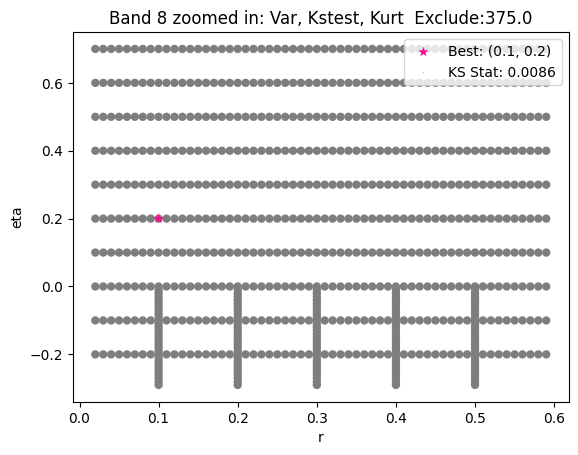

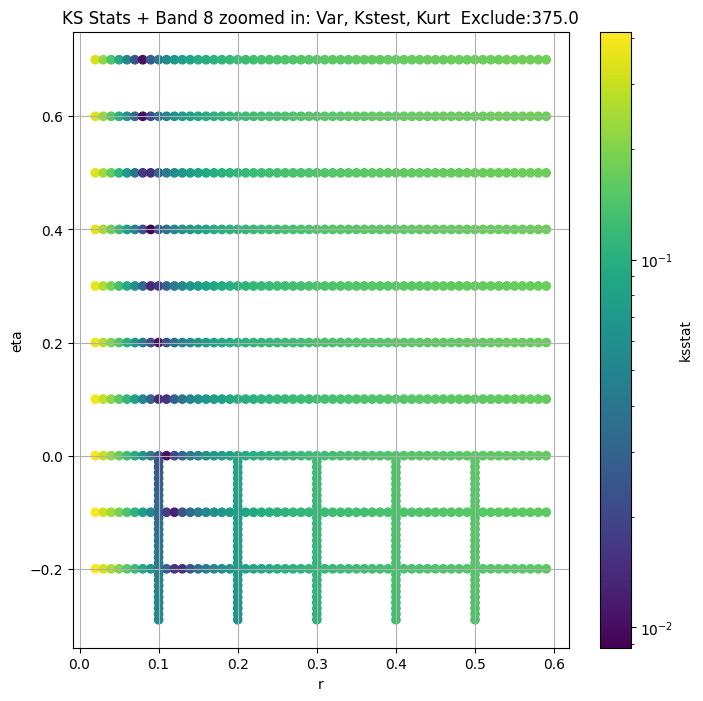

Band 9


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + 100 = 600, ksstat: 0.009672755761466532, var: 0.07444952428340912


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + 75 = 575, ksstat: 0.00937158945270105, var: 0.07675877213478088


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + 50 = 550, ksstat: 0.009247670334267422, var: 0.07919485121965408


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + 25 = 525, ksstat: 0.009086865071646799, var: 0.08176974952220917


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + 0 = 500, ksstat: 0.009185243598588577, var: 0.08449620008468628


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + -25 = 475, ksstat: 0.00863696092041144, var: 0.08738663792610168


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + -50 = 450, ksstat: 0.010201154187975958, var: 0.09045898169279099


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + -75 = 425, ksstat: 0.009486381733742333, var: 0.09372828155755997


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 9, 500.0 + -100 = 400, ksstat: 0.010209720384602439, var: 0.09721606969833374
Number of samples: 100000, Without approximation : 28783661.0


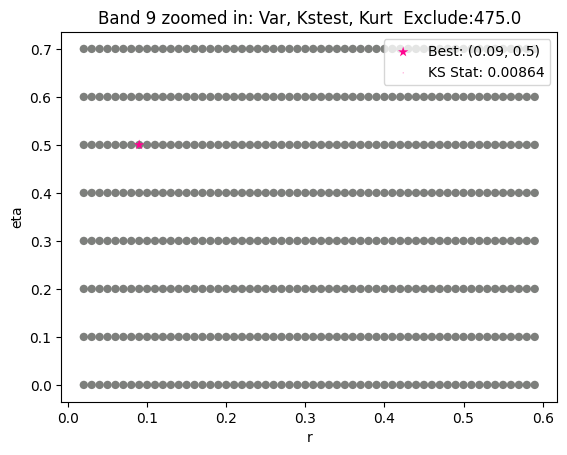

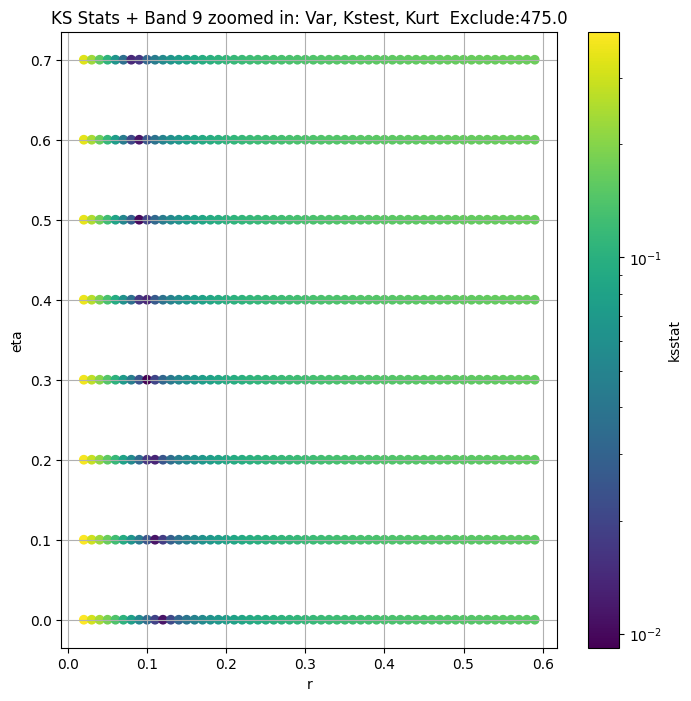

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,35.930350,30.706068,46.672894,65.41619,13.719309,295.32263,6119361.0,0.003536,0.5,-1.0,1.461662e+01,100.0,32.383686,0.000549,0.001233,0.40,-0.95,5.600808e+00,25.0,1225251
3,24.800020,19.868608,36.966910,162.30330,23.848286,629.88650,7252576.0,0.003727,0.3,-0.9,4.522399e-01,100.0,19.814962,0.000504,0.002217,0.30,-0.93,5.554635e-01,50.0,382459
4,22.749765,17.699577,34.964066,197.49574,34.756207,726.18604,8839077.0,0.003768,0.1,-0.3,1.777415e-11,0.0,22.749765,0.000457,0.002499,0.10,-0.31,1.892523e-11,0.0,310747
5,12.425893,9.770795,17.029290,119.05834,39.765420,404.69530,10425578.0,0.007320,0.1,-0.2,3.376829e-12,150.0,8.714137,0.000421,0.006192,0.09,-0.10,2.502292e-14,100.0,45814
6,11.137615,8.458925,17.432486,220.17760,43.897568,770.97736,12465365.0,0.007129,0.1,-0.2,2.625591e-12,200.0,7.066610,0.000385,0.006826,0.08,0.10,1.855263e-17,125.0,41083
7,4.457747,3.310526,7.184396,260.92682,46.247795,878.40810,14958438.0,0.007081,0.1,-0.1,5.715668e-13,200.0,2.372909,0.000351,0.007081,0.10,-0.10,5.715668e-13,200.0,36973
8,0.989298,0.736347,1.620235,274.10986,43.866005,922.87164,17904797.0,0.010164,0.1,0.2,2.246408e-14,350.0,0.419589,0.000321,0.008595,0.10,0.20,2.176831e-14,375.0,26227
9,0.287136,0.203042,0.548710,512.60270,57.122345,1514.20340,28783661.0,0.009185,0.1,0.3,2.760088e-15,500.0,0.087387,0.000253,0.008637,0.09,0.50,1.050784e-17,475.0,23715


In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

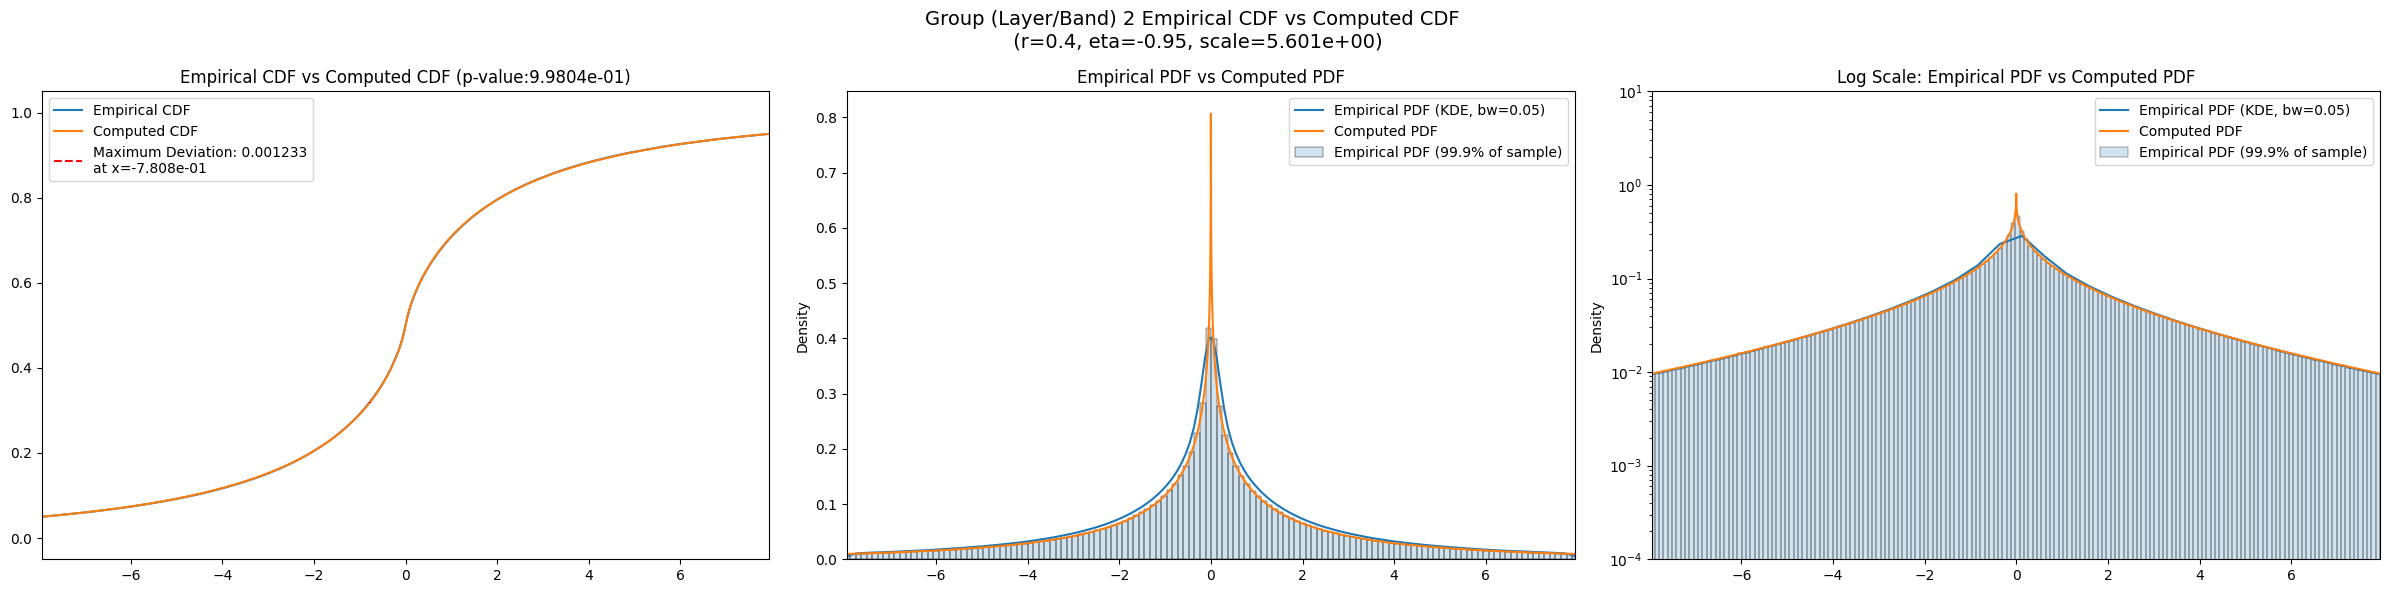

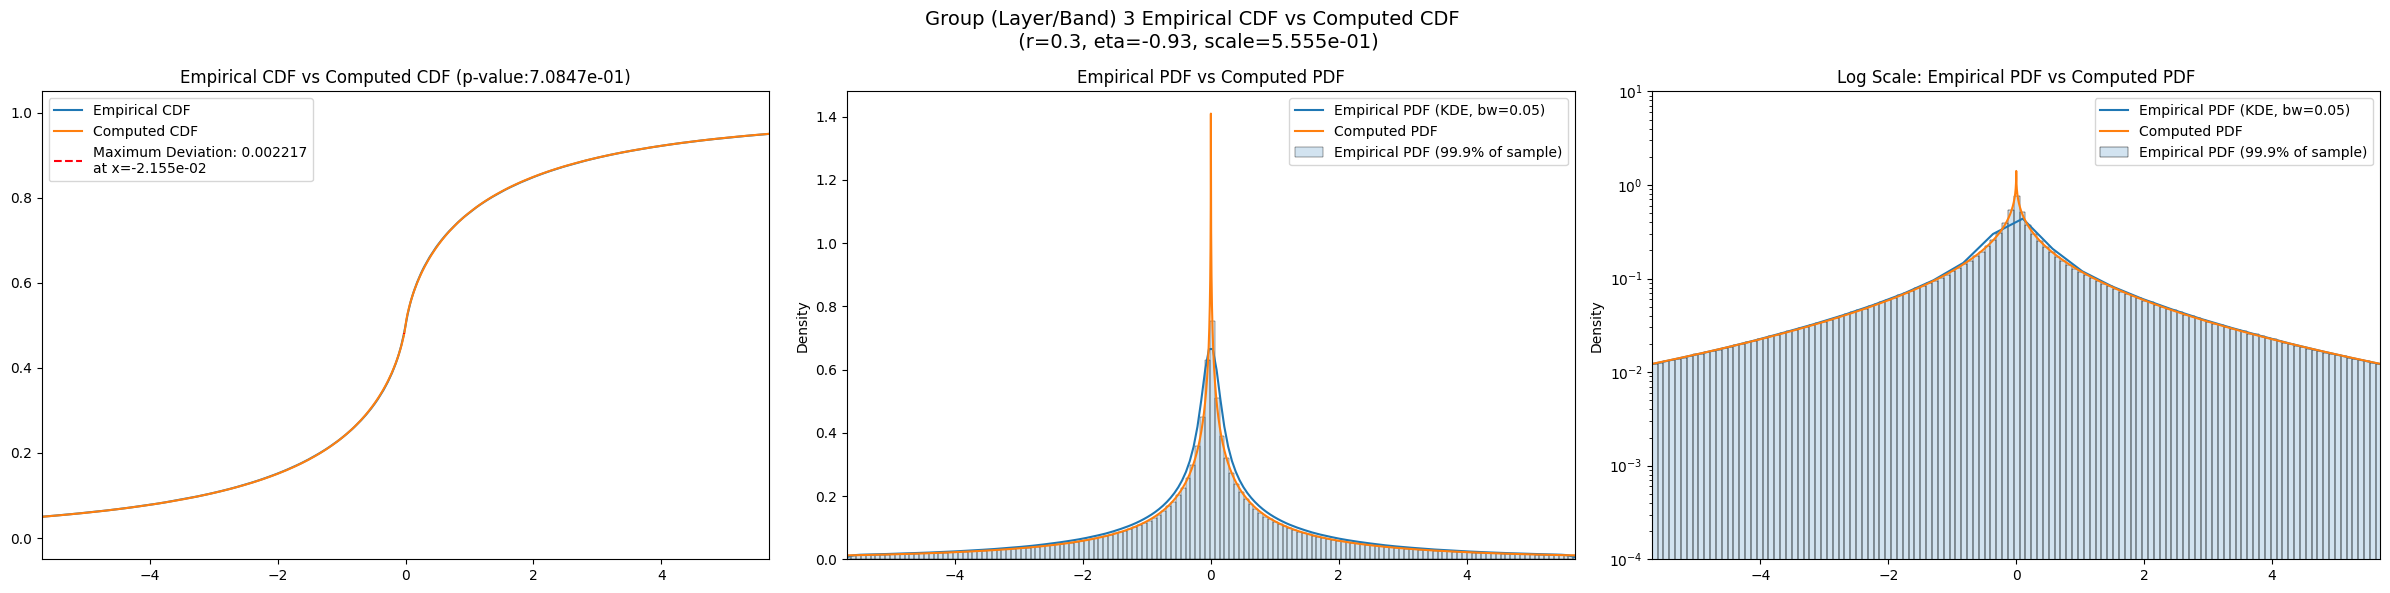

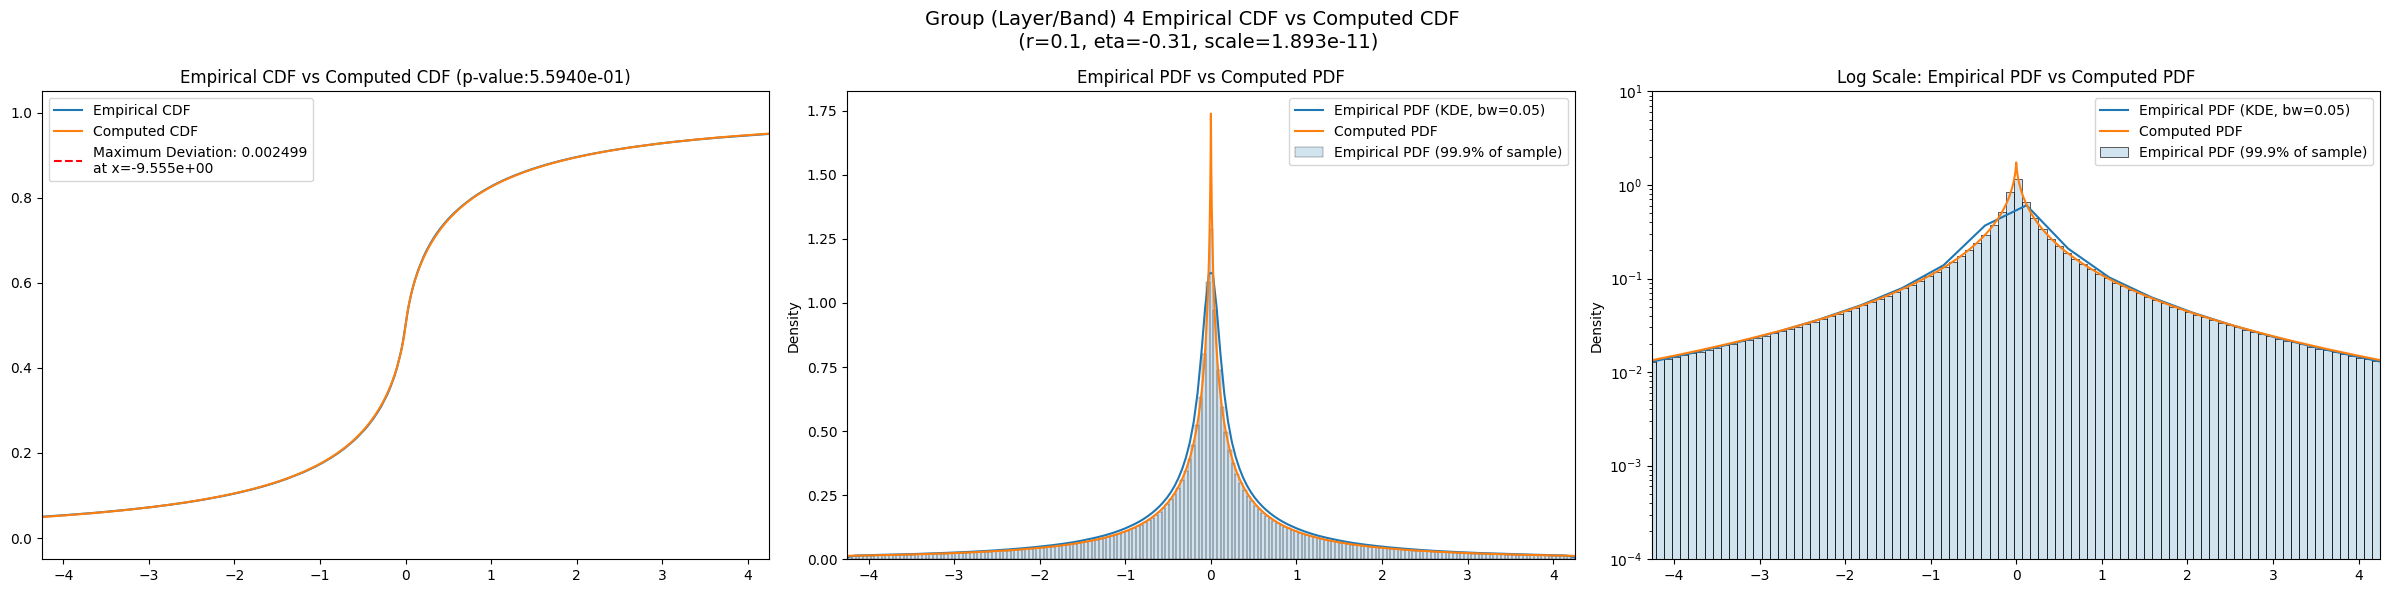

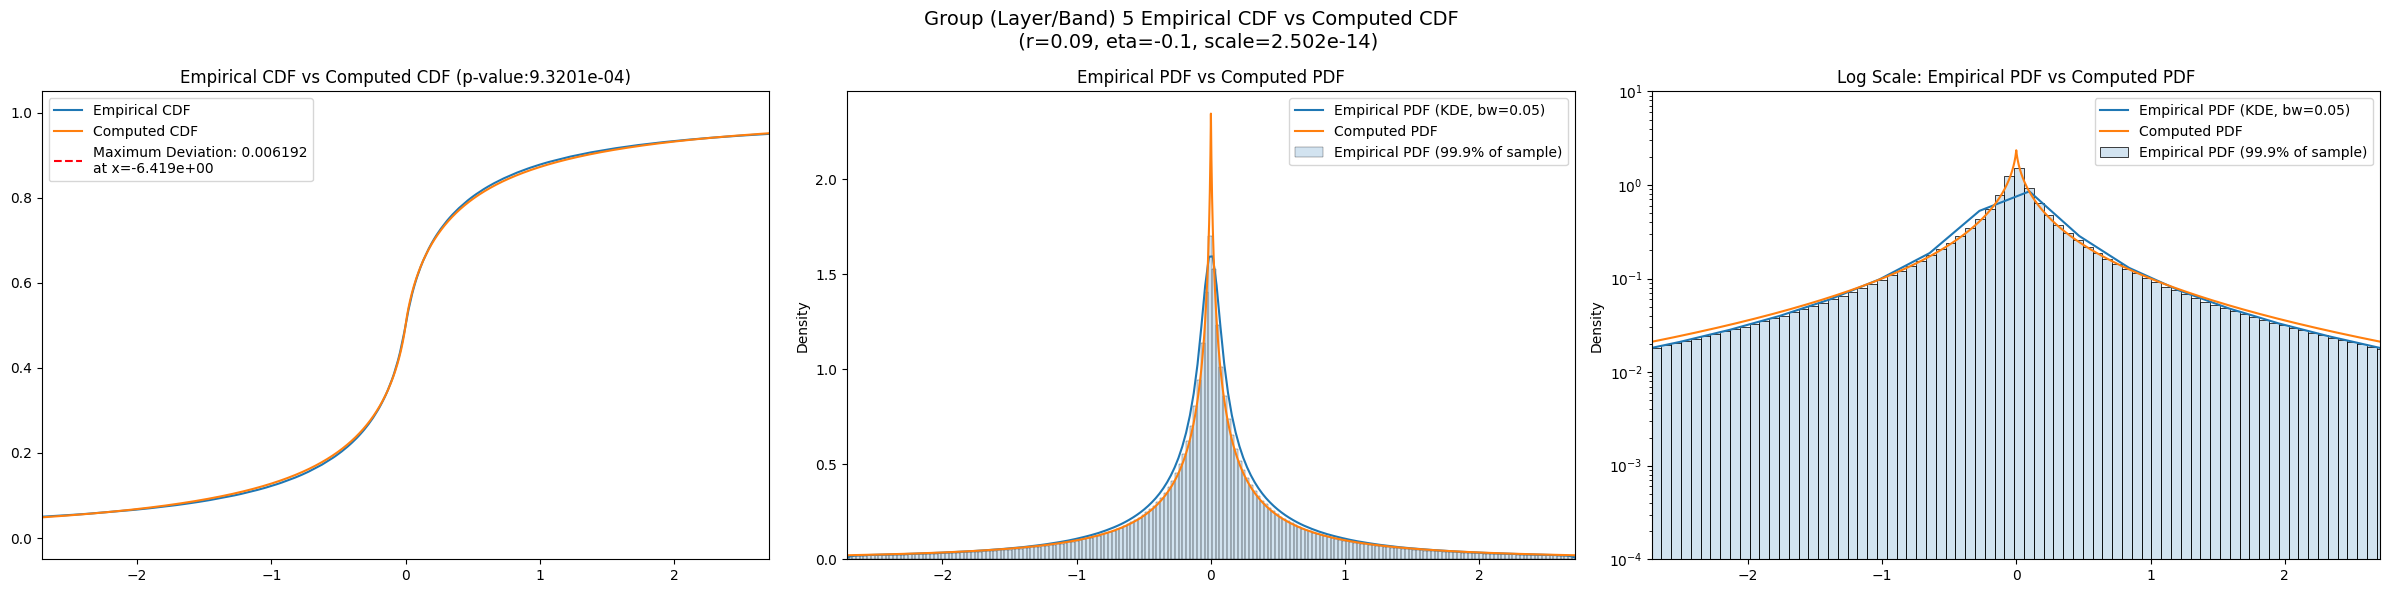

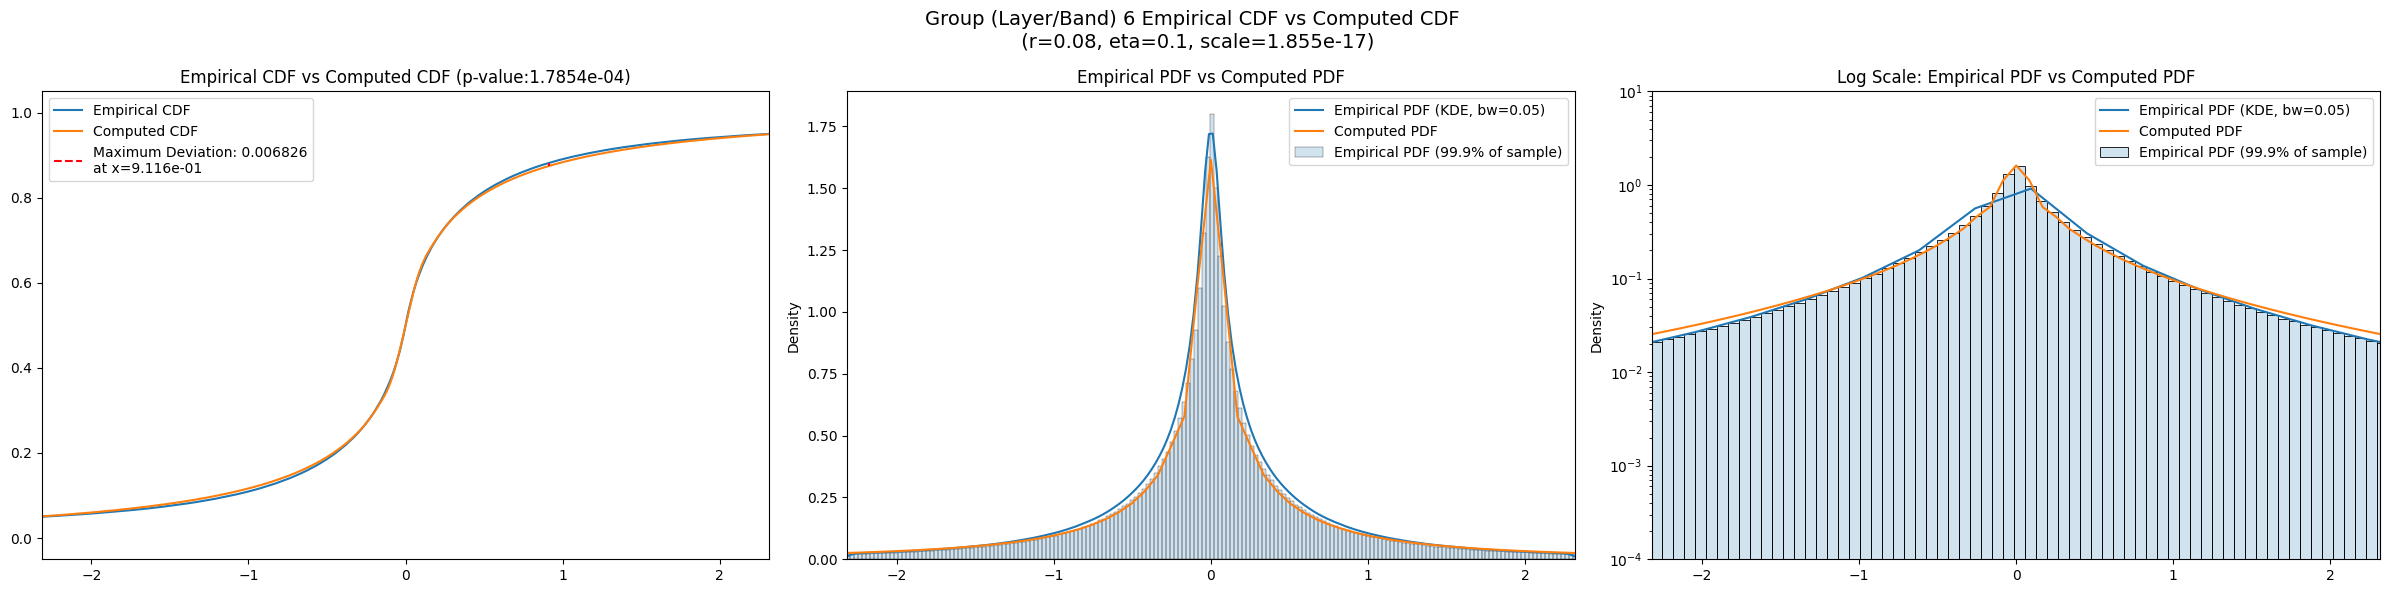

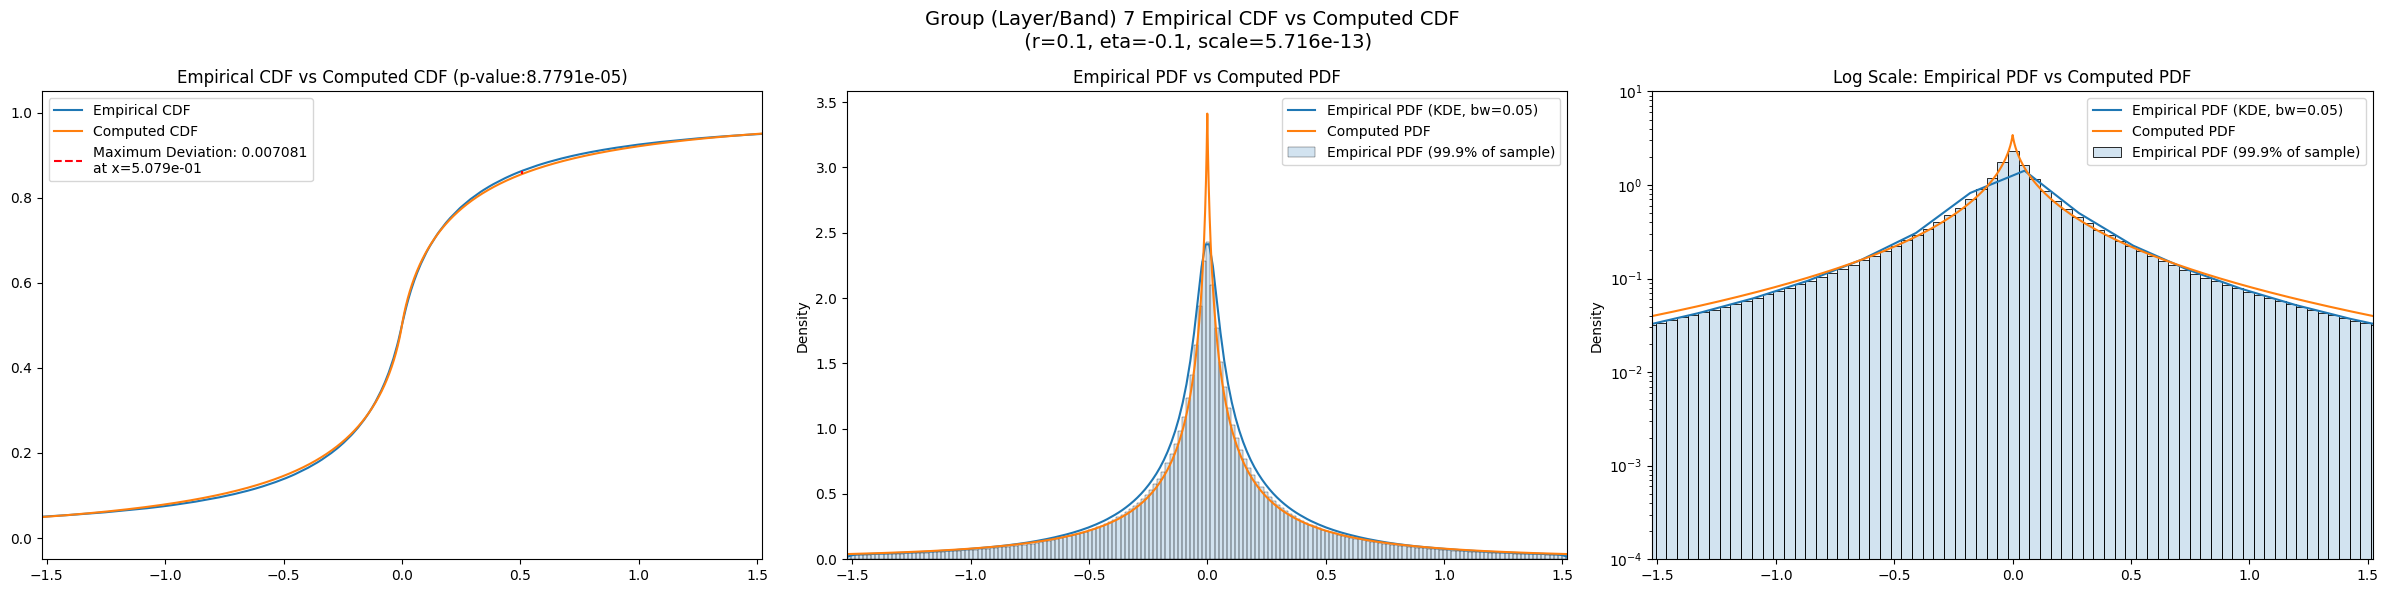

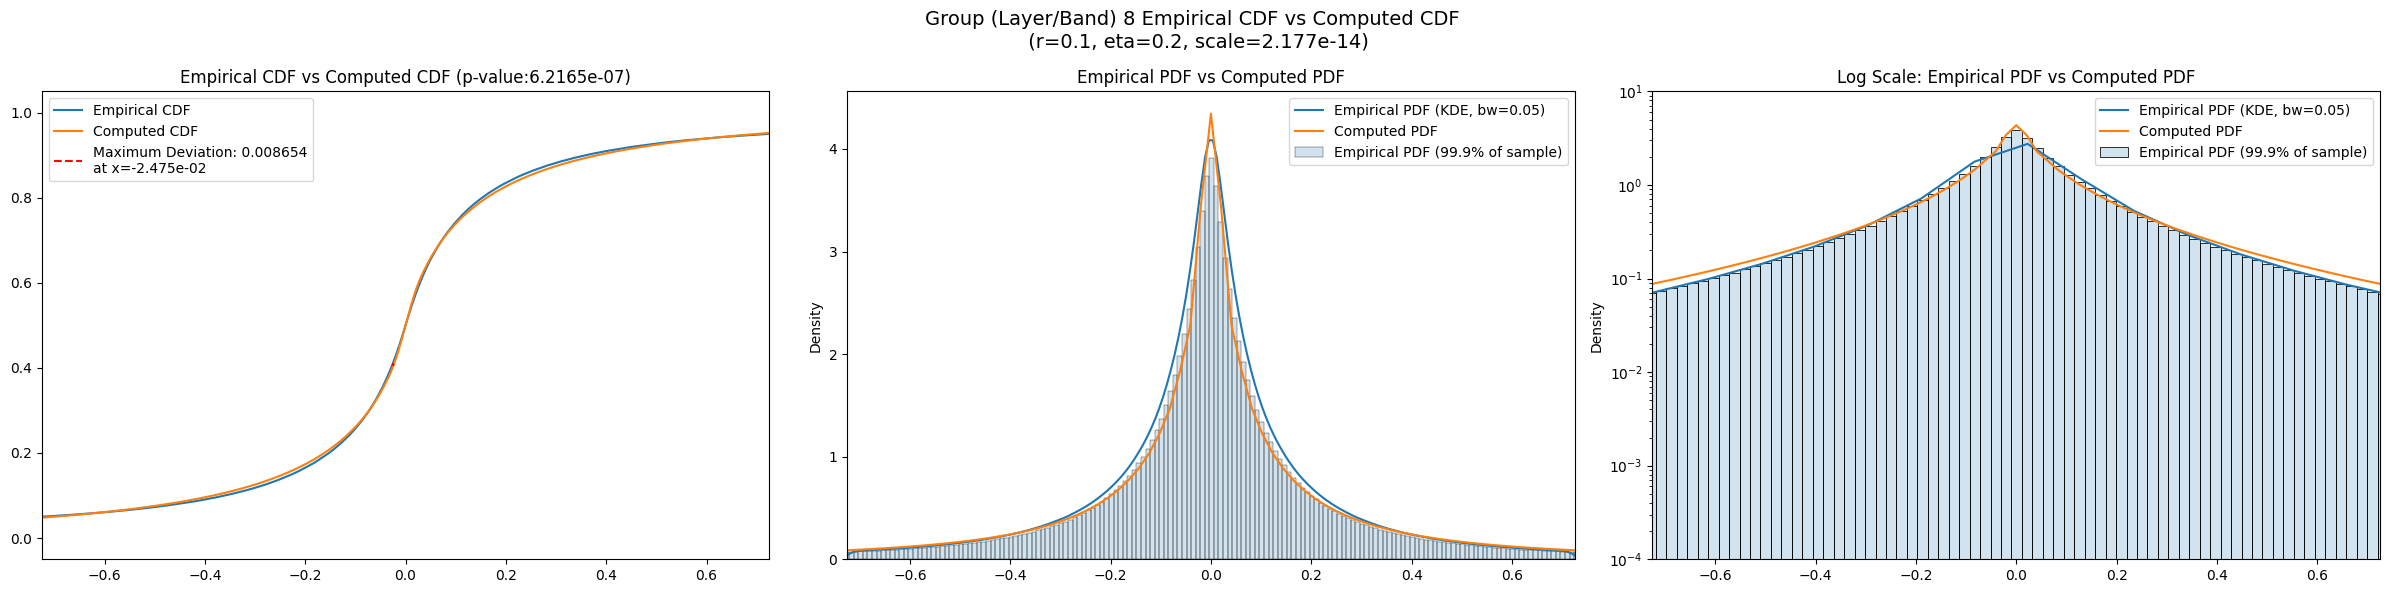

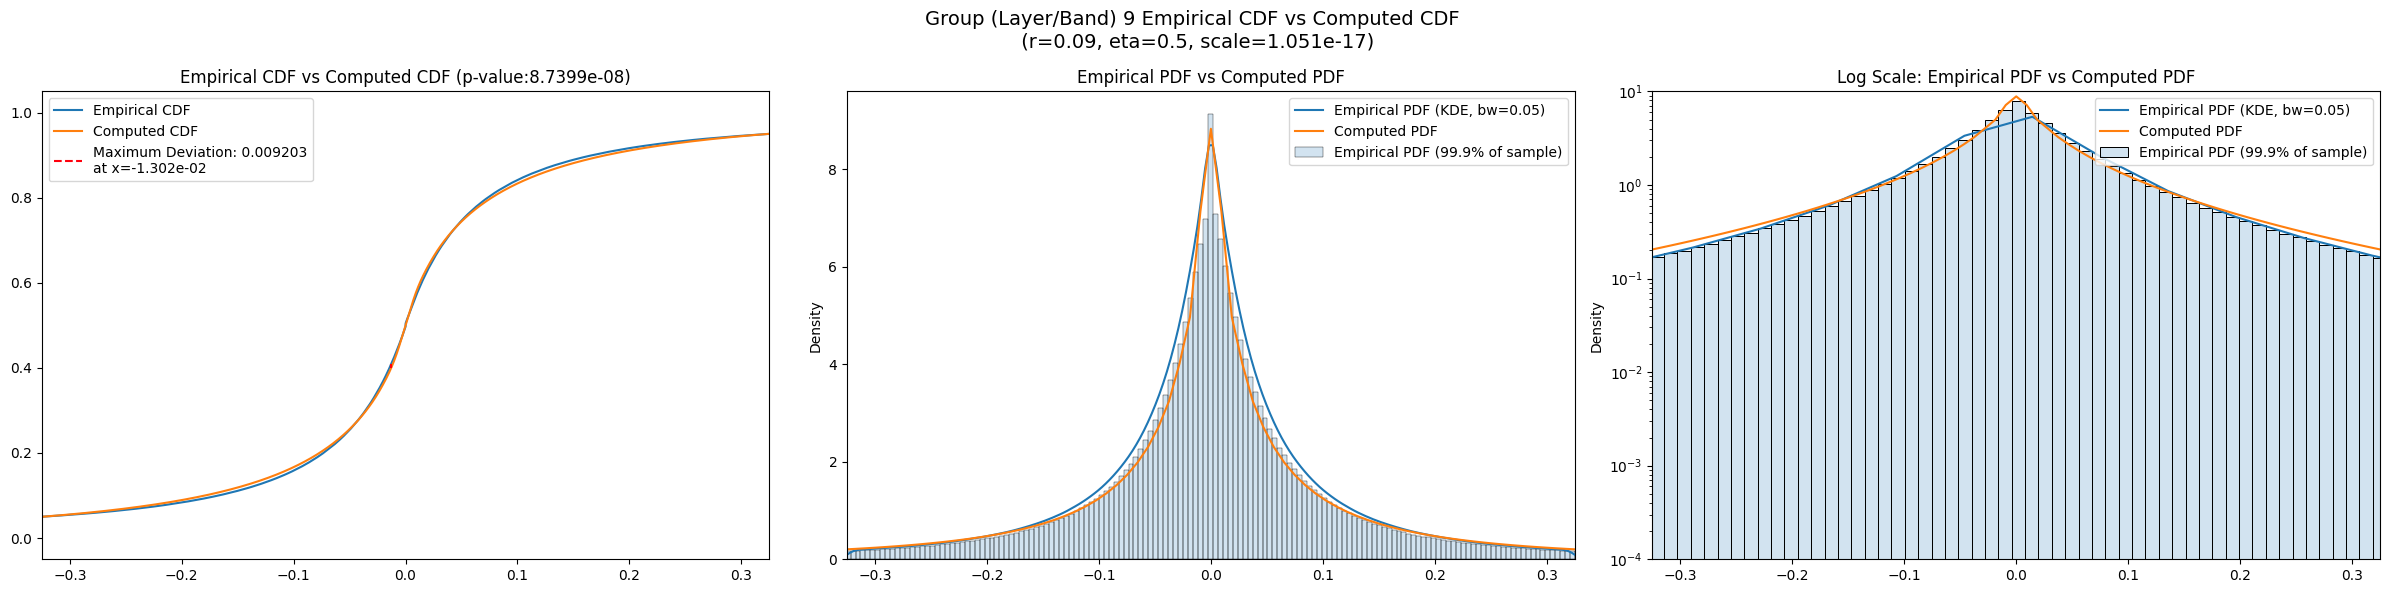

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,35.930350,30.706068,46.672894,65.41619,13.719309,295.32263,6119361.0,0.003536,0.5,-1.0,...,2.634520,0.064212,0.0,2.277430,0.038289,0.0,1.784690,0.040035,0.0,1.655641e-08
3,24.800020,19.868608,36.966910,162.30330,23.848286,629.88650,7252576.0,0.003727,0.3,-0.9,...,1.686170,0.072039,0.0,1.454470,0.046533,0.0,1.133250,0.047794,0.0,2.151336e-31
4,22.749765,17.699577,34.964066,197.49574,34.756207,726.18604,8839077.0,0.003768,0.1,-0.3,...,1.021950,0.080872,0.0,0.892121,0.055887,0.0,0.682829,0.055133,0.0,2.207272e-48
5,12.425893,9.770795,17.029290,119.05834,39.765420,404.69530,10425578.0,0.007320,0.1,-0.2,...,0.656969,0.076401,0.0,0.581543,0.051586,0.0,0.443063,0.049361,0.0,0.000000e+00
6,11.137615,8.458925,17.432486,220.17760,43.897568,770.97736,12465365.0,0.007129,0.1,-0.2,...,0.592493,0.072805,0.0,0.525013,0.048031,0.0,0.400145,0.045777,0.0,0.000000e+00
7,4.457747,3.310526,7.184396,260.92682,46.247795,878.40810,14958438.0,0.007081,0.1,-0.1,...,0.402610,0.070765,0.0,0.358421,0.045961,0.0,0.273436,0.043126,0.0,0.000000e+00
8,0.989298,0.736347,1.620235,274.10986,43.866005,922.87164,17904797.0,0.010164,0.1,0.2,...,0.210253,0.065088,0.0,0.188572,0.040425,0.0,0.144810,0.036223,0.0,0.000000e+00
9,0.287136,0.203042,0.548710,512.60270,57.122345,1514.20340,28783661.0,0.009185,0.1,0.3,...,0.101020,0.061457,0.0,0.090612,0.036751,0.0,0.069733,0.032480,0.0,0.000000e+00


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.003536,0.000549,0.001233,0.064212,0.038289,0.040035
3,0.003727,0.000504,0.002217,0.072039,0.046533,0.047794
4,0.003768,0.000457,0.002499,0.080872,0.055887,0.055133
5,0.007320,0.000421,0.006192,0.076401,0.051586,0.049361
6,0.007129,0.000385,0.006826,0.072805,0.048031,0.045777
7,0.007081,0.000351,0.007081,0.070765,0.045961,0.043126
8,0.010164,0.000321,0.008595,0.065088,0.040425,0.036223
9,0.009185,0.000253,0.008637,0.061457,0.036751,0.032480


In [21]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,32.383686,0.001233,0.40,-0.95,5.600808e+00,25.0
3,19.814962,0.002217,0.30,-0.93,5.554635e-01,50.0
4,22.749765,0.002499,0.10,-0.31,1.892523e-11,0.0
5,8.714137,0.006192,0.09,-0.10,2.502292e-14,100.0
6,7.066610,0.006826,0.08,0.10,1.855263e-17,125.0
7,2.372909,0.007081,0.10,-0.10,5.715668e-13,200.0
8,0.419589,0.008595,0.10,0.20,2.176831e-14,375.0
9,0.087387,0.008637,0.09,0.50,1.050784e-17,475.0
